In [40]:
using GraphPPL
using Rocket
using ReactiveMP
using Distributions
using Plots
using LinearAlgebra
using Random
using JLD
using Parameters
import ProgressMeter
using CSV
using DataFrames

In [41]:
import ReactiveMP.messageout

In [42]:
data_seed, params_seed = 42, 420

(42, 420)

In [125]:
# find order
delay_y, delay_u, delay_e = 4, (5+1), 1
order_h = delay_e + 1

2

In [126]:
full_order = delay_e + delay_y + delay_u
Y = zeros(full_order, delay_y); Y[1:delay_y, 1:delay_y] = diageye(delay_y);
U = zeros(full_order, delay_u); U[delay_y+1:delay_y+delay_u, 1:delay_u] = diageye(delay_u);
H = zeros(full_order, order_h); H[full_order-delay_e+1:full_order, order_h-delay_e+1:order_h] = diageye(delay_e);

In [127]:
# # changed 
# full_order = delay_e + delay_y + delay_u
# U = zeros(full_order, delay_u); U[1:delay_u, 1:delay_u] = diageye(delay_u);
# Y = zeros(full_order, delay_y); Y[delay_u+1:delay_u+delay_y, 1:delay_y] = diageye(delay_y);
# H = zeros(full_order, order_h); H[full_order-delay_e+1:full_order, order_h-delay_e+1:order_h] = diageye(delay_e);

In [128]:
# Nonlinear MAX model definition
@model [default_factorisation=MeanField()] function linear_max_mv(n, h_prior, w_prior, η_prior, τ_prior, y_prev, u, delay_y, delay_u, delay_e)
    
    order = delay_y + delay_u + delay_e
    order_h = delay_e + 1
    
    obs_prec = 1e12;
    
    # initialize variables
    θ       = randomvar() where {form_constraint = FixedMarginalConstraint(MvNormalMeanPrecision(zeros(order_h), 1e12*diageye(order_h)))}
    w       = randomvar()
    h       = randomvar(n)
    uh      = randomvar(n)
    yuh     = randomvar(n)
    yuh_     = randomvar(n)
    y       = datavar(Float64, n)

    y_nodes = Vector{FactorNode}(undef, n)

    
    Ys = [Y*y_prev[t] for t in 1:n]
    Us = [U*u[t] for t in 1:n]
    
    AR_meta_1 = ARMeta(Multivariate, order_h, ARsafe())
    AR_meta_2 = ARMeta(Multivariate, order, ARsafe())
    
    h_0 ~ MvNormalMeanPrecision(h_prior[1], h_prior[2])
    w   ~ GammaShapeRate(w_prior[1], w_prior[2])
    θ   ~ MvNormalMeanPrecision(zeros(order_h), diageye(order_h))
    
    η   ~ MvNormalMeanPrecision(η_prior[1], η_prior[2])
    τ   ~ GammaShapeRate(τ_prior[1], τ_prior[2])
    
    b = zeros(order); b[1] = 1.0;
    c = zeros(order_h); c[1] = 1.0;
    
    h_prev = h_0
    for t in 1:n
        
        h[t] ~ AR(h_prev, θ, w) where {q = q(y, x)q(γ)q(θ), meta = AR_meta_1}
        uh[t] ~ H*h[t] + Us[t]
        yuh[t] ~ uh[t] + Ys[t]
        yuh_[t] ~ AR(yuh[t], η, τ) where {q = q(y, x)q(γ)q(θ), meta = AR_meta_2}
        
        y_nodes[t], y[t] ~ dot(yuh_[t], b) + dot(h[t], c)
        
        h_prev = h[t]
    end

    return θ, w, h, η, τ, y_nodes, y
end

┌ Warning: `form_constraint` option is deprecated. Use `marginal_form_constraint` option for variable θ instead.
└ @ GraphPPL /Users/apodusenko/.julia/dev/GraphPPL/src/backends/reactivemp.jl:270


In [129]:
function linear_max_inference_mv(observations, observations_prev, controls;
                                 delay_y, delay_u, delay_e,
                                 h_prior=(randn(delay_e+1), diageye(delay_e+1)),
                                 w_prior=(1.0, 1.0), η_prior=(zeros(delay_y + delay_u + delay_e), diageye(delay_y + delay_u + delay_e)),
                                 τ_prior=(1.0, 1.0), vmp_its=10)
    
    order = delay_y + delay_u + delay_e
    order_h = delay_e + 1

    n = length(observations)

    # define model
    model, (θ, w, h, η, τ, y_nodes, y) = linear_max_mv(model_options(limit_stack_depth = 500), n, h_prior, w_prior, η_prior, τ_prior, observations_prev, controls, delay_y, delay_u, delay_e,)
    
    h_buffer = Vector{Marginal}(undef, n)
    y_out_buffer = Vector{AbstractMessage}(undef, n)
    
    θ_buffer = nothing
    w_buffer = nothing
    η_buffer = nothing
    τ_buffer = nothing
    
    subscribe!(getmarginals(h), (x) -> copyto!(h_buffer, x))
    
    subscribe!(getmarginal(θ), (x) -> θ_buffer = x)
    subscribe!(getmarginal(η), (x) -> η_buffer = x)
    subscribe!(getmarginal(w), (x) -> w_buffer = x)
    subscribe!(getmarginal(τ), (x) -> τ_buffer = x)

    subscribe!(collectLatest(messageout.(ReactiveMP.getinterface.(y_nodes, :out))), 
                                         (x) -> copyto!(y_out_buffer, ReactiveMP.as_message.(x)))
    
    # initialize free energy
    fe_buffer = Vector()
    
    # subscribe
    fe_sub = subscribe!(score(BetheFreeEnergy(), model), (f) -> push!(fe_buffer, f))
    
    setmarginals!(h, MvNormalMeanPrecision(zeros(order_h), diageye(order_h)))
    setmarginal!(w, GammaShapeRate(w_prior[1], w_prior[2]))
    setmarginal!(θ, MvNormalMeanPrecision(zeros(order_h), diageye(order_h)))
    setmarginal!(τ, GammaShapeRate(τ_prior[1], τ_prior[2]))
    setmarginal!(η, MvNormalMeanPrecision(η_prior[1], η_prior[2]))
    
    setmessages!(h, MvNormalMeanPrecision(zeros(order_h), diageye(order_h)))
    
    ProgressMeter.@showprogress for _ in 1:vmp_its
        ReactiveMP.update!(y, observations)
    end
    
    # return the marginal values
    return fe_buffer, h_buffer, θ_buffer, w_buffer, η_buffer, τ_buffer, y_out_buffer
    
end

linear_max_inference_mv (generic function with 1 method)

In [130]:
# H = zeros(delay_e, order_h); H[1:end,end-delay_e+1:end] = diageye(delay_e);

In [131]:
# # Nonlinear MAX model definition
# @model [default_factorisation=MeanField()] function linear_max_mv_(n, h_prior, w_prior, η_priors, τ_prior, y_prev, u, delay_y, delay_u, delay_e)
    
#     order = delay_e
#     order_h = delay_e + 1
    
#     obs_prec = 1e12;
    
#     # initialize variables
#     θ       = randomvar() where {form_constraint = FixedMarginalConstraint(MvNormalMeanPrecision(zeros(order_h), 1e12*diageye(order_h)))}
#     w       = randomvar()
#     h       = randomvar(n)
#     u_      = randomvar(n)
#     x       = randomvar(n)
#     ux      = randomvar(n)
#     h_      = randomvar(n)
#     xuh_    = randomvar(n)
#     y       = datavar(Float64, n)
#     Hh      = randomvar(n)

#     y_nodes = Vector{FactorNode}(undef, n)

    
#     AR_meta_1 = ARMeta(Multivariate, order_h, ARsafe())
#     AR_meta_2 = ARMeta(Multivariate, order, ARsafe())
    
#     h_0 ~ MvNormalMeanPrecision(h_prior[1], h_prior[2])
#     w   ~ GammaShapeRate(w_prior[1], w_prior[2])
#     θ   ~ MvNormalMeanPrecision(zeros(order_h), diageye(order_h))
    
#     ηx   ~ MvNormalMeanPrecision(mean(η_priors[1]), precision(η_priors[1]))
#     ηu   ~ MvNormalMeanPrecision(mean(η_priors[2]), precision(η_priors[2]))
#     ηh   ~ MvNormalMeanPrecision(mean(η_priors[3]), precision(η_priors[3]))
    
#     τ   ~ GammaShapeRate(τ_prior[1], τ_prior[2])
    
#     b = zeros(order); b[1] = 1.0;
#     c = zeros(order_h); c[1] = 1.0;
    
#     h_prev = h_0
#     for t in 1:n
        
#         h[t] ~ AR(h_prev, θ, w) where {q = q(y, x)q(γ)q(θ), meta = AR_meta_1}

#         u_[t] ~ dot(u[t], ηu)
#         x[t]  ~ dot(y_prev[t], ηx)
#         ux[t] ~ u_[t] + x[t]
        
#         Hh[t] ~ H*h[t]
#         h_[t] ~ AR(Hh[t], ηh, τ) where {q = q(y, x)q(γ)q(θ), meta = AR_meta_2}
        
#         xuh_[t] ~ ux[t] + dot(h_[t], b)
        
#         y_nodes[t], y[t] ~ xuh_[t] + dot(h[t], c)
        
#         h_prev = h[t]
#     end

#     return θ, w, h, ηh, ηu, ηx, τ, y_nodes, y, h_, x, ux, u_, Hh
# end

In [132]:
# function linear_max_inference_mv_(observations, observations_prev, controls;
#                                  delay_y, delay_u, delay_e,
#                                  h_prior=(randn(delay_e+1), diageye(delay_e+1)),
#                                  w_prior=(1.0, 1.0), η_priors,
#                                  τ_prior=(1.0, 1.0), vmp_its=10)
    
#     order = delay_e
#     order_h = delay_e + 1

#     n = length(observations)

#     # define model
#     model, (θ, w, h, ηh, ηu, ηx, τ, y_nodes, y, h_, x, ux, u_, Hh) = linear_max_mv_(n, h_prior, w_prior, η_priors, τ_prior, observations_prev, controls, delay_y, delay_u, delay_e,
#                                                                  options = (limit_stack_depth = 100, ))
    
#     h_buffer = Vector{Marginal}(undef, n)
#     y_out_buffer = Vector{AbstractMessage}(undef, n)
    
#     θ_buffer  = nothing
#     w_buffer  = nothing
#     ηx_buffer = nothing
#     ηu_buffer = nothing
#     ηh_buffer = nothing
#     τ_buffer  = nothing
    
#     subscribe!(getmarginals(h), (x) -> copyto!(h_buffer, x))
    
#     subscribe!(getmarginal(θ), (x) -> θ_buffer = x)
    
#     subscribe!(getmarginal(ηh), (x) -> ηh_buffer = x)
#     subscribe!(getmarginal(ηu), (x) -> ηu_buffer = x)
#     subscribe!(getmarginal(ηx), (x) -> ηx_buffer = x)
    
#     subscribe!(getmarginal(w), (x) -> w_buffer = x)
#     subscribe!(getmarginal(τ), (x) -> τ_buffer = x)

#     subscribe!(collectLatest(messageout.(ReactiveMP.getinterface.(y_nodes, :out))), 
#                                          (x) -> copyto!(y_out_buffer, ReactiveMP.as_message.(x)))
    
#     # initialize free energy
#     fe_buffer = Vector()
    
#     # subscribe
#     fe_sub = subscribe!(score(BetheFreeEnergy(), model), (f) -> push!(fe_buffer, f))
    
#     setmessages!(x, NormalMeanPrecision(0.0, 1.0))
#     setmessages!(u_, NormalMeanPrecision(0.0, 1.0))
#     setmessages!(ux, NormalMeanPrecision(0.0, 1.0))
#     setmessages!(Hh, MvNormalMeanPrecision(zeros(order), diageye(order)))
    
    
#     setmarginals!(h, MvNormalMeanPrecision(zeros(order_h), diageye(order_h)))
#     setmarginal!(w, GammaShapeRate(w_prior[1], w_prior[2]))
#     setmarginal!(θ, MvNormalMeanPrecision(zeros(order_h), diageye(order_h)))
#     setmarginal!(τ, GammaShapeRate(τ_prior[1], τ_prior[2]))
    
#     setmarginal!(ηx, MvNormalMeanPrecision(mean(η_priors[1]), precision(η_priors[1])))
#     setmarginal!(ηu, MvNormalMeanPrecision(mean(η_priors[2]), precision(η_priors[2])))
#     setmarginal!(ηh, MvNormalMeanPrecision(mean(η_priors[3]), precision(η_priors[3])))
    
#     setmessages!(h, MvNormalMeanPrecision(zeros(order_h), diageye(order_h)))
#     setmessages!(h_, MvNormalMeanPrecision(zeros(delay_e), diageye(delay_e)))

#     ProgressMeter.@showprogress for _ in 1:vmp_its
#         ReactiveMP.update!(y, observations)
#     end
    
#     # return the marginal values
#     return fe_buffer, h_buffer, θ_buffer, w_buffer, ηx_buffer, ηu_buffer, ηh_buffer, τ_buffer, y_out_buffer
    
# end

In [167]:
df = DataFrame(CSV.File("../datasets/cascadedtanks/dataBenchmark.csv"));
u_train, u_val, y_train, y_val = df[:,1], df[:,2], df[:,3], df[:,4]

# normalization
m_y, s_y = mean(y_train), std(y_train)
m_u, s_u = mean(u_train), std(u_train)
output_trn = (y_train .- m_y) ./ s_y
output_val = (y_val .- m_y) ./ s_y
input_trn = (u_train .- m_u) ./ s_u
input_val = (u_val .- m_u) ./ s_u;


# output_trn = y_train
# output_val = y_val
# input_trn = u_train
# input_val = u_val
output_trn = collect(Iterators.flatten([output_trn[1:10:end] for i in 1:10]))
output_val = collect(Iterators.flatten([output_val[1:10:end] for i in 1:10]))
input_trn = collect(Iterators.flatten([input_trn[1:10:end] for i in 1:10]))
input_val = collect(Iterators.flatten([input_val[1:10:end] for i in 1:10]))

1030-element Vector{Float64}:
 -1.8238110623262187
 -1.4776008606670765
 -0.1487000866142361
 -0.0020000011649533964
 -0.11390006634405844
 -0.4670002720164626
 -0.580200337952787
  0.033200019338214745
  0.11690006809148631
 -0.5547003230996401
 -0.34990020380848064
 -0.3408001985079456
  1.1878006918654247
  ⋮
 -0.805300469068217
 -0.5719003331182334
  0.1983001155050623
 -0.8565004988910067
 -1.7081009949278785
 -2.2626813179576204
 -1.6008009324281645
 -0.13670007962451972
  0.6606003847838854
  0.5198003027712133
 -1.16310067747826
 -1.9459411334640568

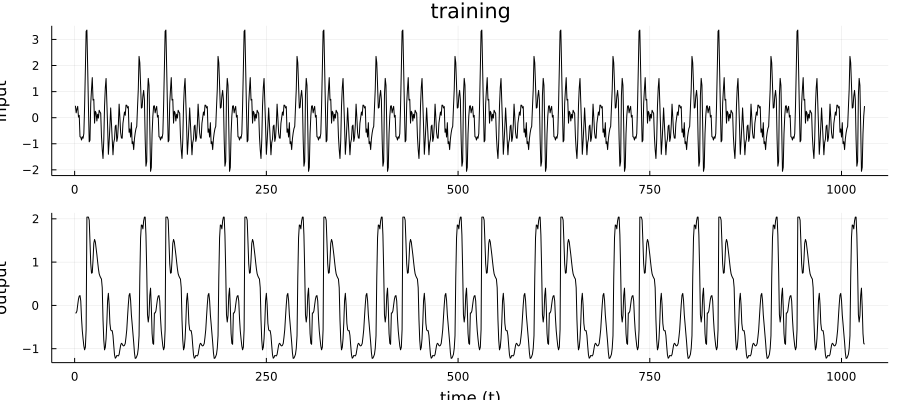

In [168]:
# Plot every n-th time-point to avoid figure size exploding
n = 1
ix = 1:n:length(output_trn)

# Plot training signals
p1a = plot(ix, input_trn[ix], color="black", label="", xlabel="", ylabel="input", title="training")    
p1b = plot(ix, output_trn[ix], color="black", label="", xlabel="time (t)", ylabel="output", size=(900,400))    
p1 = plot(p1a, p1b, layout=(2,1))

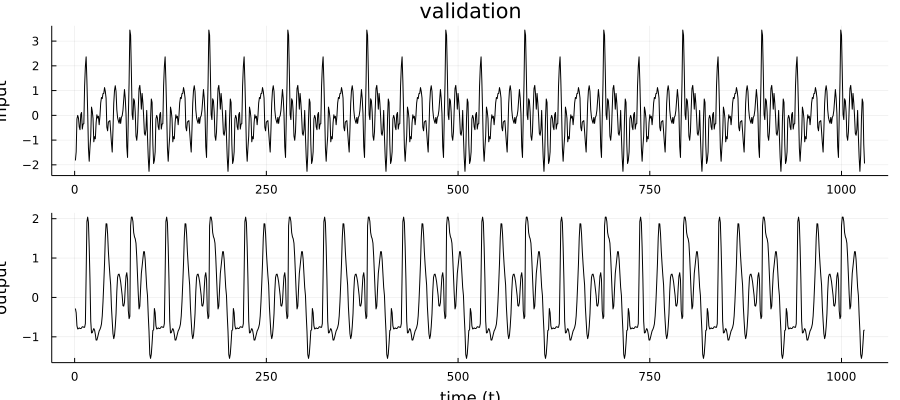

In [169]:
n = 1
ix = 1:n:length(output_val)

# Plot validation signals
p1a = plot(ix, input_val[ix], color="black", label="", xlabel="", ylabel="input", title="validation")    
p1b = plot(ix, output_val[ix], color="black", label="", xlabel="time (t)", ylabel="output", size=(900,400))    
p1 = plot(p1a, p1b, layout=(2,1))

In [170]:
function ssm(series, order)
    inputs = [reverse!(series[1:order])]
    outputs = [series[order + 1]]
    for x in series[order+2:end]
        push!(inputs, vcat(outputs[end], inputs[end])[1:end-1])
        push!(outputs, x)
    end
    return inputs, outputs
end

ssm (generic function with 1 method)

In [173]:
train_size = 1000
test_size = 1000
# train_size = 100
# test_size = 50

# Generate training data
observations_prev, observations = ssm(output_trn, delay_y)
controls = ssm(input_trn, delay_u)[1]
X_train, Y_train, U_train = observations_prev[1:train_size], observations[1:train_size], controls[1:train_size];

# Generate validation data
observations_prev, observations = ssm(output_val, delay_y)
controls = ssm(input_val, delay_u)[1]
X_test, Y_test, U_test = observations_prev[1:test_size], observations[1:test_size], controls[1:test_size];

In [174]:
include("../helpers/nonlinear_node.jl")

In [175]:
full_order = delay_y + delay_u + delay_e
coefs_precision = 1e-10*diageye(full_order)
coefs_mean = zeros(full_order); 
# coefs_mean[end-delay_e+1:end] = zeros(delay_e)
# coefs_precision[end-delay_e+1:end,end-delay_e+1:end] = 1e5*diageye(delay_e)
# coefs_precision[1:3, 1:3] = 1e3*diageye(3)
# coefs_precision[4:7, 4:7] = 1e-10*diageye(4)
# coefs_precision[7:end, 7:end] = 1e3*diageye(4)

In [176]:


fe_, h_, θ_, w_, η_, τ_, y_out_ = linear_max_inference_mv(Y_train, X_train, U_train, delay_y=delay_y, delay_u=delay_u, delay_e=delay_e, w_prior=(0.01, 0.01), η_prior=(coefs_mean, coefs_precision), τ_prior=(100.0, 1.0), vmp_its=100);



Progress: 100%|█████████████████████████████████████████| Time: 0:00:26


In [177]:
# full_order = delay_y + delay_u + delay_e
# coefs_precision = diageye(full_order)
# coefs_mean = zeros(full_order); coefs_mean[end-delay_e+1:end] = zeros(delay_e)
# eta_priors = [MvNormalMeanPrecision(zeros(delay_y), diageye(delay_y)), MvNormalMeanPrecision(zeros(delay_u), diageye(delay_u)), MvNormalMeanPrecision(zeros(delay_e), diageye(delay_e))]

# fe_, h_, θ_, w_, ηx_, ηu_, ηh_, τ_, y_out_ = linear_max_inference_mv_(Y_train, X_train, U_train, delay_y=delay_y, delay_u=delay_u, delay_e=delay_e, w_prior=(1e4, 1.0), η_priors=eta_priors, τ_prior=(1e2, 1.0), vmp_its=100);


In [178]:
fe_

100-element Vector{Any}:
 -23113.797200663597
 -39481.82105741295
 -39114.24505346437
 -29408.063529944324
  -1872.9207895084073
  -1104.6804869013595
  -2307.303307476617
  -2403.762288099075
  -2594.0737146023603
  -2723.68479036964
  -2822.1068659506564
  -2901.2497677016727
  -2966.190339885521
      ⋮
  -2455.2236277058837
  -2448.7196908932165
  -2442.122405441696
  -2435.6664370372237
  -2429.383617535437
  -2422.8244630313784
  -2416.5757856326964
  -2410.1386051649242
  -2404.0587994462185
  -2397.6585892335424
  -2391.3323780402134
  -2385.2270561549158

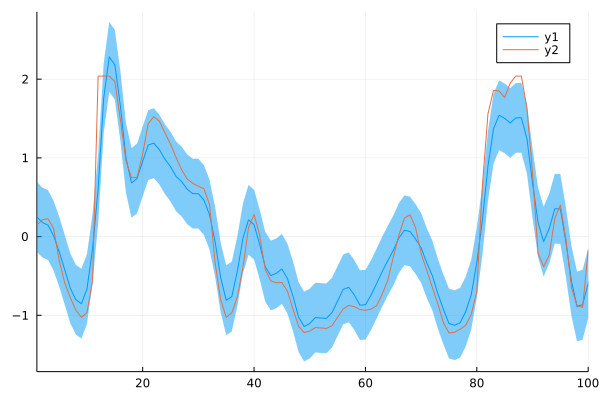

In [181]:
mfrom, mto = 1, 100
plot(mean.(y_out_), ribbon=sqrt.(cov.(y_out_)))
# plot!(first.(U_train))
plot!(Y_train, xlims=(mfrom, mto))

In [182]:
mean(w_)

555.5399196355253

In [183]:
mean(τ_)

109.18560595006389

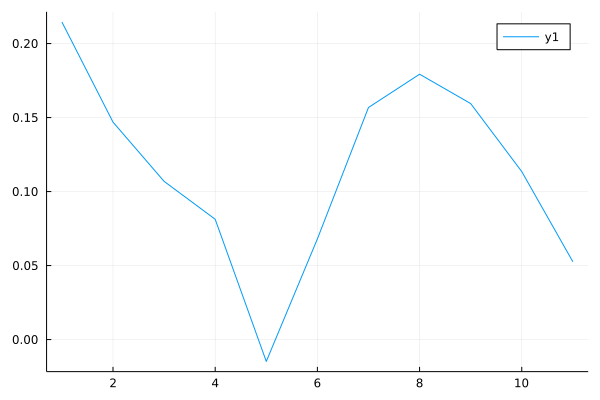

In [184]:
plot(mean(η_))

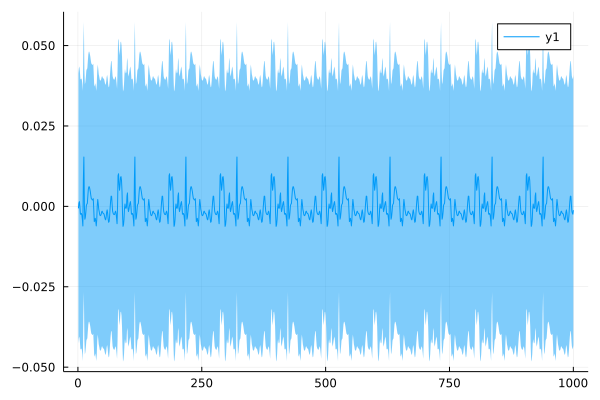

In [185]:
plot(first.(mean.(h_)), ribbon=sqrt.(first.(cov.(h_))))

## Prediction

In [186]:
function transition(γ, order)
    V = zeros(order, order)
#     V = diageye(order)
    V[1] = 1/γ
    return V
end

function shift(dim)
    S = Matrix{Float64}(I, dim, dim)
    for i in dim:-1:2
           S[i,:] = S[i-1, :]
    end
    S[1, :] = zeros(dim)
    return S
end

shift (generic function with 1 method)

In [187]:
function prediction(h_prior, w_mle, η_posterior, τ_posterior, y_prev, u; full_order, h_order, nsamples=100)
    h_out = @call_rule MvNormalMeanCovariance(:out, Marginalisation) (m_μ=MvNormalMeanPrecision(mean(h_prior), precision(h_prior)), q_Σ=PointMass(transition(mean(w_), order_h)))
    Ys = Y*y_prev
    Us = U*u
    h_ = @call_rule typeof(*)(:out, Marginalisation) (m_A=PointMass(H), m_in=h_out)
    uh = @call_rule typeof(+)(:out, Marginalisation) (m_in1=PointMass(Us), m_in2=h_)
    yuh = @call_rule typeof(+)(:out, Marginalisation) (m_in1=PointMass(Ys), m_in2=uh)
    ar_out = @call_rule AR(:y, Marginalisation) (m_x=yuh, q_θ=η_posterior.data, q_γ=τ_posterior.data, meta=ARMeta(Multivariate, full_order, ARsafe()))
    c = zeros(full_order); c[1] = 1.0
    dot_out = @call_rule typeof(dot)(:out, Marginalisation) (m_in1=PointMass(c), m_in2=ar_out, meta=ReactiveMP.TinyCorrection())
    c = zeros(h_order); c[1] = 1.0
    c_out = @call_rule typeof(dot)(:out, Marginalisation) (m_in1=PointMass(c), m_in2=h_out, meta=ReactiveMP.TinyCorrection())
    @call_rule typeof(+)(:out, Marginalisation) (m_in1=dot_out, m_in2=c_out)
end

prediction (generic function with 1 method)

In [188]:
h_prior = h_[end]
prediction(h_prior, mean(w_), η_, τ_, X_test[1], U_test[1], full_order=full_order, h_order=order_h, nsamples=1000)

NormalMeanVariance{Float64}(μ=-0.8133549889127778, v=0.19821553473751694)

In [189]:
predictions = []
h_prior = h_[end]
w_prior = w_
τ_prior = τ_
ProgressMeter.@showprogress for i in 1:length(Y_test)
    pred = prediction(h_prior, mean(w_), η_, τ_, X_test[i], U_test[i], full_order=full_order, h_order=order_h, nsamples=1000)
    push!(predictions, pred)
    _, h_post, θ_post, w_post, η_post, τ_post, _ = linear_max_inference_mv([Y_test[i]], [X_test[i]], [U_test[i]], 
                                                                            delay_y=delay_y, delay_u=delay_u, delay_e=delay_e, 
                                                                            h_prior=(mean(h_prior), precision(h_prior)),
                                                                            w_prior=(shape(w_prior), rate(w_prior)), 
                                                                            η_prior=(mean(η_), precision(η_)),
                                                                            τ_prior=(shape(τ_prior), rate(τ_prior)), vmp_its=10);
    h_prior = h_post[end]
    η_prior = η_post
    τ_prior = τ_post
    w_prior = w_post
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:03


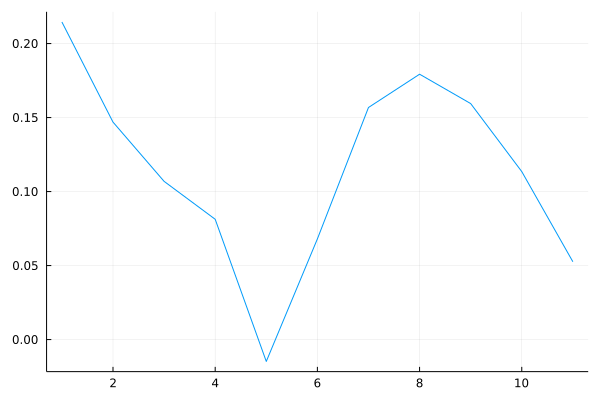

In [190]:
plot(mean(η_), label=false)

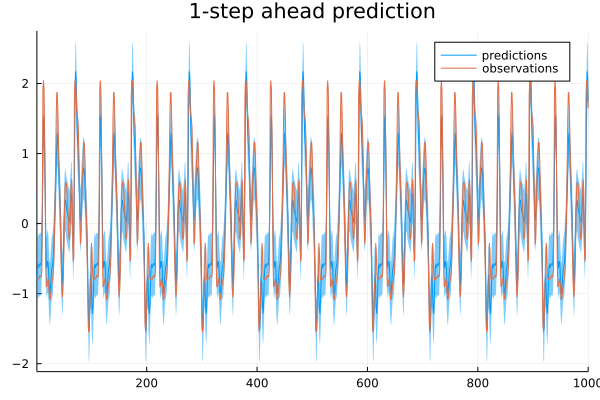

In [191]:
plot(mean.(predictions), ribbon=sqrt.(first.(cov.(predictions))), label="predictions")
plot!(Y_test, xlims=(1, 1000), title="1-step ahead prediction", label="observations")

In [192]:
RMSE = sqrt(mean((mean.(predictions) .- Y_test) .^2))

0.3276610743057753

In [193]:
h_prior = h_[end]
w_prior = w_
τ_prior = τ_
η_prior = η_

simulated_X = [X_test[1]]
simulated_Y = [Y_test[1]]
simulated_Y_cov = [0.0]
simulated_error = [h_[end]]

ProgressMeter.@showprogress for i in 1:length(Y_test)
    _, h_post, θ_post, w_post, η_post, τ_post, y_out_post = linear_max_inference_mv([simulated_Y[i]], [simulated_X[i]], [U_test[i]],
                                                                                     delay_y=delay_y, delay_u=delay_u, delay_e=delay_e, 
                                                                                     h_prior=(mean(h_prior), precision(h_prior)),
                                                                                     w_prior=(shape(w_prior), rate(w_prior)), 
                                                                                     η_prior=(mean(η_prior), precision(η_prior)),
                                                                                     τ_prior=(shape(τ_prior), rate(τ_prior)), vmp_its=10);


    h_prior = h_post[end]
#     η_prior = η_post
#     τ_prior = τ_post
#     w_prior = w_post
    
    push!(simulated_X, [mean.(y_out_post)[1]; simulated_X[i][1:delay_y-1]])
    pred_sim = prediction(h_prior, mean(w_), η_prior, τ_, [mean.(y_out_post)[1]; simulated_X[i][1:delay_y-1]], U_test[i], full_order=full_order, h_order=order_h)

    push!(simulated_Y, mean(pred_sim))
    push!(simulated_Y_cov, var(pred_sim))
    push!(simulated_error, h_prior)

end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:03


In [194]:
RMSE = sqrt(mean((simulated_Y[2:end] .- Y_test).^2))

0.4213928678956301

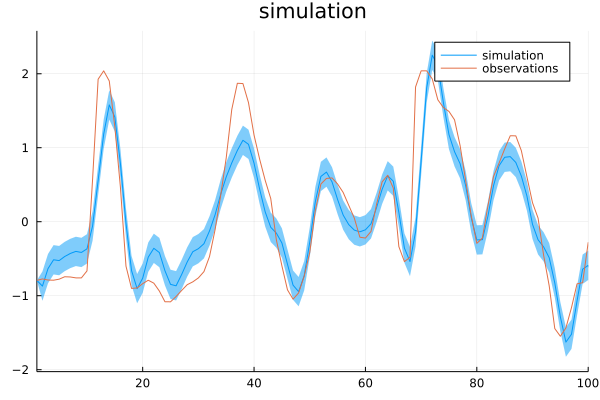

In [197]:

plot(simulated_Y,  ribbon=simulated_Y_cov, label="simulation")
# plot!(first.(U_test), label="controls")
plot!(Y_test, title="simulation", label="observations", xlims=(1, 100))